# Camera Calibration
Here we will read in 20 chessboard images for calibrating our camera.

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


CAL_IMAGES_DIR = './camera_cal/'
TEST_IMAGES_DIR = './test_images/'
X_DIM = 9
Y_DIM = 6


def get_images(dir):
    """Returns all the images in a directory as a list"""
    return [mpimg.imread(dir + image) for image in os.listdir(dir)]


def compute_cal_points(images, x_dim=X_DIM, y_dim=Y_DIM):
    """Returns a tuple that contains (object points, image points)"""
    objp = np.zeros((x_dim*y_dim, 3), np.float32)
    objp[:,:2] = np.mgrid[0:x_dim, 0:y_dim].T.reshape(-1,2)
    
    objpoints, imgpoints = [], []
    
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (x_dim, y_dim), None)
        
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    return (objpoints, imgpoints)


def undistort(image, objpoints, imgpoints):
    """Returns an undistorted image withthe given objpoints and imgpoints"""
    image_shape = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
    
    return cv2.undistort(image, mtx, dist, None, mtx)


cal_images = get_images(CAL_IMAGES_DIR)
objpoints, imgpoints = compute_cal_points(cal_images)

Here we can see a distorted image and an undistorted image below it

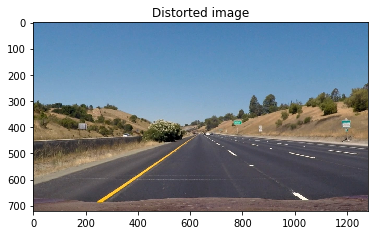

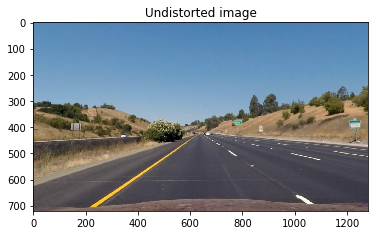

In [2]:
test_images = get_images(TEST_IMAGES_DIR)
undistorted_img = undistort(test_images[0], objpoints, imgpoints)
plt.title('Distorted image')
plt.imshow(test_images[0])
plt.show()
plt.title('Undistorted image')
plt.imshow(undistorted_img)
plt.show()

# Transform the image
Now we want to apply a perspective transform so we can view the road from a top down view

In [3]:
def distort_coeff(image_shape, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
    return (mtx, dist)


def corners_unwarp(image, mtx, dist):
    """Performs a perspective transform on an undistorted image so we can view the road from above"""
    
    # Points were found on the Udacity Slack Channel by Chris Grill
    src = np.float32([[220, 719], [1220, 719], [750, 480], [550, 480]])
    dest = np.float32([[240, 719], [1040, 719], [1040, 300], [240, 300]])
    
    M = cv2.getPerspectiveTransform(src, dest)
    image_shape = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, image_shape, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dest, src)
    return warped, M, Minv

mtx, dist = distort_coeff(test_images[0].shape[::-1][1:], objpoints, imgpoints)
warped, M, Minv = corners_unwarp(undistorted_img, mtx, dist)

Here we have an undistorted image and its perspective transform below it.

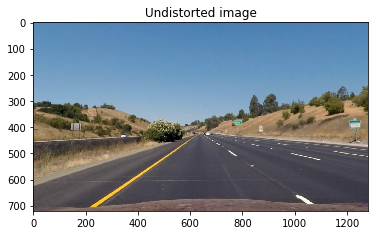

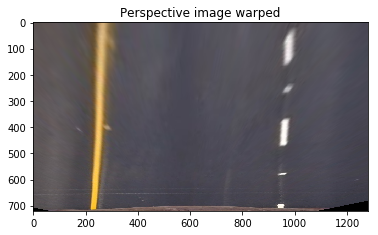

In [4]:
plt.title("Undistorted image")
plt.imshow(undistorted_img)
plt.show()

plt.title("Perspective image warped")
plt.imshow(warped)
plt.show()

# Creating a thresholded binary image
Here we will use the gradient, color transforms, and other methods to output the thresholded binary image.

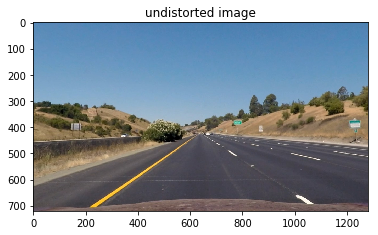

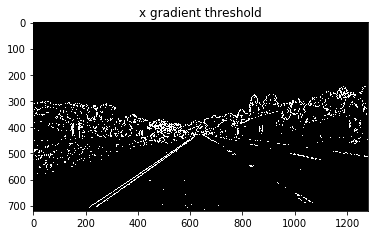

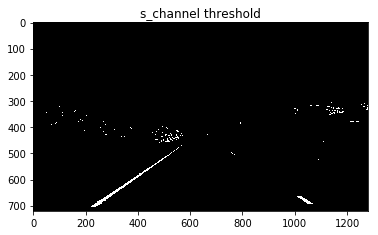

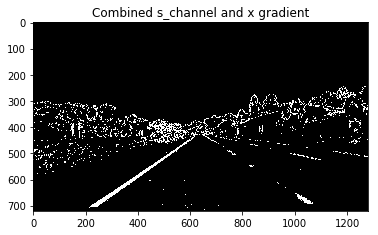

In [5]:
def grad(img, *, orient='x', sobel_kernel=3):
    """Compute the gradient across an axis"""
    if orient == 'x':
        orientation = (1, 0)
    elif orient == 'y':
        orientation = (0, 1)
    else:
        raise ValueError('{} is not a correct orientation'.format(orient))

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    grad = cv2.Sobel(gray, cv2.CV_64F, *orientation, ksize=sobel_kernel)
    return grad


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """Takes the absolute value, scales the gradient and applies a threshold"""
    sobel = grad(img, orient=orient, sobel_kernel=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return binary_out(scaled_sobel, thresh)


def binary_out(data, thresh=(0, 255)):
    """Returns the binary thresholded image for a given threshold range"""
    binary_out = np.zeros_like(data)
    binary_out[(thresh[0] <= data) & (data <= thresh[1])] = 1

    return binary_out


def display_image(image, title, gray=False):
    plt.title(title)
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()
    

def combine_grad_with_channel(image, display=False):
    ksize = 3

    scaled_sobel_x = abs_sobel_thresh(image, 'x', ksize, (20, 100))
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    s_binary = binary_out(s_channel, (170, 255))
   
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (scaled_sobel_x == 1)] = 1
    
    if display:
        display_image(image, "undistorted image")
        display_image(scaled_sobel_x, "x gradient threshold", gray=True)
        display_image(s_binary, "s_channel threshold", gray=True)
    
    return combined_binary


image = undistorted_img
combined_binary = combine_grad_with_channel(image, display=True)
display_image(combined_binary, "Combined s_channel and x gradient", gray=True)

Here we perform the thresholding and perspective transform

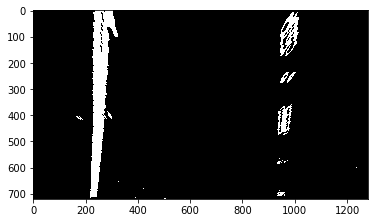

In [6]:
processed_img, M, Minv = corners_unwarp(combined_binary, mtx, dist)
plt.imshow(processed_img, cmap='gray')

In [7]:
# for image in test_images:
#     undist = undistort(image, objpoints, imgpoints)
#     combined_binary = combine_grad_with_channel(undist)
#     display_image(combined_binary, "Combined s-channel with grad", gray=True)
    
#     processed_img, _ = corners_unwarp(combined_binary, mtx, dist)
#     plt.imshow(processed_img, cmap='gray')
#     plt.show()

# Establishing pipeline for image processing
Here we will create a function that will perform the following:
    - undistortion
    - binary thresholding
    - perspective transform

In [8]:
def pipeline(image):
    undistorted_img = undistort(image, objpoints, imgpoints)
    combined_binary = combine_grad_with_channel(undistorted_img)
    processed_img, M, Minv = corners_unwarp(combined_binary, mtx, dist)
    return processed_img, M, Minv

# Detecting the left and right lanes
Here I will be using the histogram method to determine the left and right lane lines

By plotting the fully processed image, we can see that there are two major peaks.
The one on the left should be the left lane, and the one on the right should be the right lane.

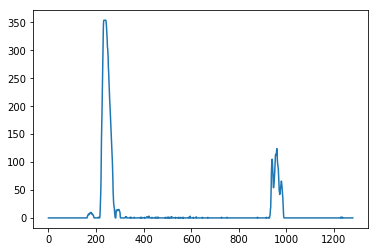

In [9]:
histogram = np.sum(processed_img[processed_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

Now we will implement a sliding window and fit a polynomial to the line

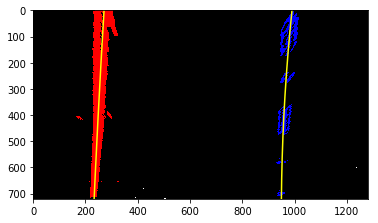

In [10]:
def fit_lines(img, histogram):
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    NUM_WINDOWS = 9
    window_height = np.int(img.shape[0]/NUM_WINDOWS)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    #out_img = np.dstack((img, img, img))*255
    for window in range(NUM_WINDOWS):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds


def display_curves(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    out_img = np.dstack((img, img, img))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    
left_fit, right_fit, left_lane_inds, right_lane_inds = fit_lines(processed_img, histogram)
display_curves(processed_img, left_fit, right_fit, left_lane_inds, right_lane_inds)

Now that you have a previous image, it is easier to find the next line's pixels

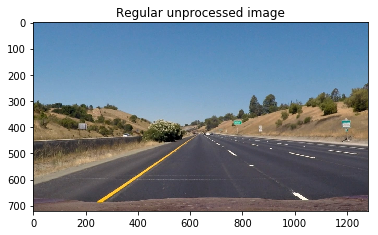

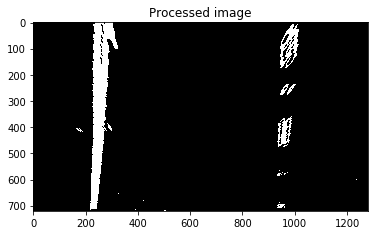

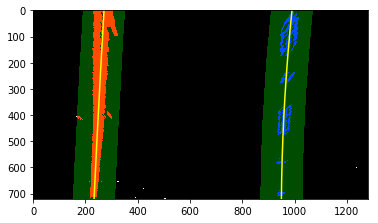

In [11]:
image = test_images[0]
processed_image, _, Minv = pipeline(image)
display_image(image, "Regular unprocessed image")
display_image(processed_img, "Processed image", gray=True)


def fit_lines_from_prev(img, left_fit, right_fit):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds
    
    
def visualize_fit(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    
left_fit, right_fit, left_lane_inds, right_lane_inds = fit_lines_from_prev(processed_img, left_fit, right_fit)
visualize_fit(processed_img, left_fit, right_fit, left_lane_inds, right_lane_inds)

# Drawing the curves back into the image

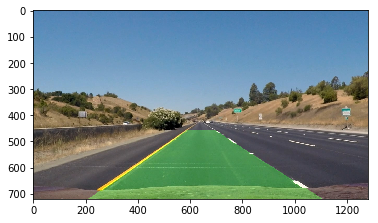

In [14]:
def draw_curves_into_image(image, Minv, processed_image, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(processed_image).astype(np.uint8)
    color_warp = np.dstack((processed_image, processed_image, processed_image))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, processed_image.shape[0]-1, processed_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    plt.show()
    
draw_curves_into_image(image, Minv, processed_image, left_fit, right_fit)

# Calculating left and right curvatures

In [20]:
def calculate_curvatures(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
calculate_curvatures(processed_image, left_fit, right_fit, left_lane_inds, right_lane_inds)

21650.6519569 m 2499.96302545 m
